# Data import and visualization

In [ ]:
!pip install shap
!pip install xgboost
!pip install imblearn
!pip install pytorch-tabnet


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import shap

import xgboost
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [ ]:
# TODO: 
# 1) Save pandas dtypes from preprocessing dataframe
# 2) Create dataset loader that loads dtypes along with csv to create the new df
# You can probably just try to export to parquet instead though

df = pd.read_parquet('/work/processed/preprocessed.parquet.gzip')
df = df.drop('identifier', axis=1)

In [ ]:
df.columns

Index(['age_band', 'x0_1.0', 'x0_2.0', 'heart_disease', 'high_bp', 'stroke',
       'circulation', 'lung_disease', 'diabetes', 'kidney_disease',
       'nervous_system', 'liver_disease', 'cancer', 'depression', 'arthritis',
       't0_assisted', 't0_disability', 't0_mobility', 't0_self_care',
       't0_activity', 't0_discomfort', 't0_anxiety', 't0_symptom_period',
       't0_living_arrangements', 'oks_t0_pain', 'oks_t0_night_pain',
       'oks_t0_washing', 'oks_t0_transport', 'oks_t0_walking',
       'oks_t0_standing', 'oks_t0_limping', 'oks_t0_kneeling', 'oks_t0_work',
       'oks_t0_confidence', 'oks_t0_shopping', 'oks_t0_stairs', 'oks_t0_score',
       't0_eq_vas', 'outcome_binary', 'outcome_readmittance',
       'outcome_satisfaction', 'outcome_pain', 'outcome_mcid_binary',
       'oks_t1_score'],
      dtype='object')

In [ ]:
for col in df.columns:
    df[col] = df[col].astype('category')

In [ ]:
df.describe()

,age_band,x0_1.0,x0_2.0,heart_disease,high_bp,stroke,circulation,lung_disease,diabetes,kidney_disease,...,oks_t0_shopping,oks_t0_stairs,oks_t0_score,t0_eq_vas,outcome_binary,outcome_readmittance,outcome_satisfaction,outcome_pain,outcome_mcid_binary,oks_t1_score
count,139236.0,139236.0,139236.0,139236.0,139236.0,139236.0,139236.0,139236.0,139236.0,139236.0,...,139236.0,139236.0,137567.0,139236.0,139236,139236,139236,139236,139236,136657.0
unique,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,5.0,5.0,49.0,101.0,2,2,2,2,2,49.0
top,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,17.0,70.0,0,1,1,1,1,44.0
freq,64458.0,83487.0,83487.0,126185.0,77666.0,136933.0,131354.0,126457.0,121857.0,136380.0,...,47355.0,59348.0,6564.0,27534.0,129832,126672,118704,111127,91412,7575.0


In [ ]:
# generate random mock labels
#df_len = df.shape[0]
#df_y = np.random.randint(2, size=df_len)

In [ ]:
def oks_questions(t='t0'):
  return [f'oks_{t}_pain', f'oks_{t}_night_pain', f'oks_{t}_washing',
          f'oks_{t}_transport', f'oks_{t}_walking', f'oks_{t}_standing',
          f'oks_{t}_limping', f'oks_{t}_kneeling', f'oks_{t}_work',
          f'oks_{t}_confidence', f'oks_{t}_shopping', f'oks_{t}_stairs', ]

def eq5d_questions(t='t0'):
  return [f'{t}_mobility', f'{t}_self_care',
          f'{t}_activity', f'{t}_discomfort', f'{t}_anxiety']

df_new_1 = oks_questions('t1')

In [ ]:
df = df.drop(columns=['oks_t1_score'], errors='ignore')

# Train-test split & evaluating outcomes

In [ ]:
# making some combination outcome - Bad Outcome or Pain = True
outcome_combined = (df["outcome_binary"] == 0) | (df["outcome_pain"] == 0)
df["outcome_combined"] = outcome_combined
outcome_combined.value_counts()

True     136670
False      2566
Name: count, dtype: int64

In [ ]:
TARGET_COLUMN = "outcome_mcid_binary"

In [ ]:
available_outcomes = [column for column in df.columns.to_numpy() if "outcome" in column]
print(available_outcomes)

['outcome_binary', 'outcome_readmittance', 'outcome_satisfaction', 'outcome_pain', 'outcome_mcid_binary', 'outcome_combined']


In [ ]:
df[TARGET_COLUMN].value_counts()

outcome_mcid_binary
1    91412
0    47824
Name: count, dtype: int64

In [ ]:
df_y = df[TARGET_COLUMN].to_numpy()
df = df.drop(columns=available_outcomes)

# class imbalance problem.
df_y_series = pd.Series(df_y)
df_y_series.value_counts()

1    91412
0    47824
Name: count, dtype: int64

In [ ]:
# use imblearn to under/oversample for class imbalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN

ros = SMOTEENN(random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

comorb = [
    "heart_disease",
    "high_bp",
    "stroke",
    "circulation",
    "lung_disease",
    "diabetes",
    "kidney_disease",
    "nervous_system",
    "liver_disease",
    "cancer",
    "depression",
    "arthritis",
]
boolean = ["t0_assisted", "t0_previous_surgery", "t0_disability"]
age_band = ["age_band"]
gender = ["gender"]
eq_vas = ["t0_eq_vas"]
eq5d = ["t0_mobility", "t0_self_care", "t0_activity", "t0_discomfort", "t0_anxiety"]
eq_vas = ["t0_eq_vas"]
categorical = ["t0_symptom_period", "t0_previous_surgery", "t0_living_arrangements"]


age_band_categories = sorted([x for x in df.age_band.unique() if isinstance(x, str)])
# preprocessing pipelines for specific columns
age_band_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=None, strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(categories=[age_band_categories])),
    ]
)
gender_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

# ColumnTransformer on all included columns.
# Note columns that are not specified are dropped by default
transformers = {
    "age": ("age", age_band_pipe, age_band),
    "gender": ("gender", gender_pipe, gender),
    "comorb": (
        "comorb",
        'passthrough',
        comorb,
    ),
    "categorical": (
        "categorical",
        SimpleImputer(missing_values=9, strategy="most_frequent"),
        boolean + eq5d + categorical,
    ),
    "oks": (
        "oks",
        'passthrough',
        oks_questions('t0'),
    ),
    "eq_vas": ("eqvas", SimpleImputer(missing_values=999, strategy="median"), eq_vas),
}
prep = ColumnTransformer(
    transformers=[v for _, v in transformers.items()])

# prep.fit(df)
# df = prep.transform(df)

In [ ]:
df.age_band

0         3.0
1         3.0
2         3.0
3         3.0
4         3.0
         ... 
139231    4.0
139232    4.0
139233    4.0
139234    4.0
139235    4.0
Name: age_band, Length: 139236, dtype: category
Categories (6, float64): [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [ ]:
df.describe()

,age_band,x0_1.0,x0_2.0,heart_disease,high_bp,stroke,circulation,lung_disease,diabetes,kidney_disease,...,oks_t0_walking,oks_t0_standing,oks_t0_limping,oks_t0_kneeling,oks_t0_work,oks_t0_confidence,oks_t0_shopping,oks_t0_stairs,oks_t0_score,t0_eq_vas
count,139236.0,139236.0,139236.0,139236.0,139236.0,139236.0,139236.0,139236.0,139236.0,139236.0,...,139236.0,139236.0,139236.0,139236.0,139236.0,139236.0,139236.0,139236.0,137567.0,139236.0
unique,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,49.0,101.0
top,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,17.0,70.0
freq,64458.0,83487.0,83487.0,126185.0,77666.0,136933.0,131354.0,126457.0,121857.0,136380.0,...,57845.0,61442.0,61848.0,61499.0,60496.0,42028.0,47355.0,59348.0,6564.0,27534.0


In [ ]:
df.isna().any()

age_band                  False
x0_1.0                    False
x0_2.0                    False
heart_disease             False
high_bp                   False
stroke                    False
circulation               False
lung_disease              False
diabetes                  False
kidney_disease            False
nervous_system            False
liver_disease             False
cancer                    False
depression                False
arthritis                 False
t0_assisted               False
t0_disability             False
t0_mobility               False
t0_self_care              False
t0_activity               False
t0_discomfort             False
t0_anxiety                False
t0_symptom_period         False
t0_living_arrangements    False
oks_t0_pain               False
oks_t0_night_pain         False
oks_t0_washing            False
oks_t0_transport          False
oks_t0_walking            False
oks_t0_standing           False
oks_t0_limping            False
oks_t0_k

In [ ]:
df.drop(columns="oks_t0_score", errors='ignore', inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.to_numpy(), df_y, test_size=0.2, random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)

In [ ]:
for index, item in enumerate(df.columns.to_list()):
    print(f"{index}: {item}\n")

0: age_band

1: x0_1.0

2: x0_2.0

3: heart_disease

4: high_bp

5: stroke

6: circulation

7: lung_disease

8: diabetes

9: kidney_disease

10: nervous_system

11: liver_disease

12: cancer

13: depression

14: arthritis

15: t0_assisted

16: t0_disability

17: t0_mobility

18: t0_self_care

19: t0_activity

20: t0_discomfort

21: t0_anxiety

22: t0_symptom_period

23: t0_living_arrangements

24: oks_t0_pain

25: oks_t0_night_pain

26: oks_t0_washing

27: oks_t0_transport

28: oks_t0_walking

29: oks_t0_standing

30: oks_t0_limping

31: oks_t0_kneeling

32: oks_t0_work

33: oks_t0_confidence

34: oks_t0_shopping

35: oks_t0_stairs

36: t0_eq_vas



# Start training!

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [ ]:
xgb = xgboost.XGBClassifier(tree_method="hist", random_state=42, enable_categorical=True)
xgb.fit(X_train, y_train)

"""
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

svc = SVC(probability=True)
svc.fit(X_train, y_train)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
# tabnet = TabNetClassifier()
# tabnet_clf.fit(X_train, y_train)
"""

'\nlogreg = LogisticRegression()\nlogreg.fit(X_train, y_train)\n\nsvc = SVC(probability=True)\nsvc.fit(X_train, y_train)\n\ngnb = GaussianNB()\ngnb.fit(X_train, y_train)\n# tabnet = TabNetClassifier()\n# tabnet_clf.fit(X_train, y_train)\n'

In [ ]:
from sklearn.model_selection import GridSearchCV

# try and make GridSearch

# parameters taken from https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
}

gridsearch_xgb = GridSearchCV(xgb, params, scoring="roc_auc", n_jobs=-1)
# gridsearch_xgb.fit(X_train, y_train)
# best_clf = gridsearch_xgb.best_classifier_

In [ ]:
len(df.columns.to_list())
df.columns.to_list()

['age_band',
 'x0_1.0',
 'x0_2.0',
 'heart_disease',
 'high_bp',
 'stroke',
 'circulation',
 'lung_disease',
 'diabetes',
 'kidney_disease',
 'nervous_system',
 'liver_disease',
 'cancer',
 'depression',
 'arthritis',
 't0_assisted',
 't0_disability',
 't0_mobility',
 't0_self_care',
 't0_activity',
 't0_discomfort',
 't0_anxiety',
 't0_symptom_period',
 't0_living_arrangements',
 'oks_t0_pain',
 'oks_t0_night_pain',
 'oks_t0_washing',
 'oks_t0_transport',
 'oks_t0_walking',
 'oks_t0_standing',
 'oks_t0_limping',
 'oks_t0_kneeling',
 'oks_t0_work',
 'oks_t0_confidence',
 'oks_t0_shopping',
 'oks_t0_stairs',
 't0_eq_vas']

In [ ]:
xyz_cols = "age_band,x0_1.0,x0_2.0,heart_disease,high_bp,stroke,circulation,lung_disease,diabetes,kidney_disease,nervous_system,liver_disease,cancer,depression,arthritis,t0_assisted,t0_previous_surgery,t0_disability,t0_mobility,t0_self_care,t0_activity,t0_discomfort,t0_anxiety,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,oks_t0_pain,oks_t0_night_pain,oks_t0_washing,oks_t0_transport,oks_t0_walking,oks_t0_standing,oks_t0_limping,oks_t0_kneeling,oks_t0_work,oks_t0_confidence,oks_t0_shopping,oks_t0_stairs,oks_t0_pain_total,oks_t0_functioning_total,oks_t0_score,t0_eq_vas".split(",")


missing_cols = [col for col in xyz_cols if col not in df.columns.to_list()]
missing_cols

['t0_previous_surgery',
 't0_previous_surgery',
 'oks_t0_pain_total',
 'oks_t0_functioning_total',
 'oks_t0_score']

# Stacking Ensemble

In [ ]:
from sklearn.ensemble import StackingClassifier

models = [('lr', LogisticRegression()), ('svm', SVC()), ('xgb', xgboost.XGBClassifier())]
stacking = StackingClassifier(estimators=models, final_estimator=LogisticRegression(), cv=5)
stacking.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

KeyboardInterrupt



# Evaluation

In [ ]:
# cross-validation evaluation (for train set)
def evaluate_train_cv(clf, X_train, y_train) -> None:
    """
    Cross-validation function for training set.

    Parameters:
        clf: Classifier to be evaluated. Must follow sklearn API
        X_train: Input values for training set. Usually np.ndarray or pd.DataFrame
        y_train: Ground truths for training set. Usually np.ndarray or pd.Series

    Returns:
        None
    """
    auroc_scores = []

    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    curr_fold = 1

    # X_train = X_train.reset_index(drop=True).to_numpy()
    
    for train_idx, test_idx in strat_kfold.split(X_train, y_train):
        # get fold sets & train model
        X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
        y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]
        clf.fit(X_train_fold, y_train_fold)

        # predict using trained model
        y_test_pred_proba = clf.predict_proba(X_test_fold)
        y_test_pred_proba_pos = y_test_pred_proba[: ,1]
        y_test_pred = (y_test_pred_proba_pos >= 0.5).astype(int)

        # get stats & print em
        auroc = roc_auc_score(y_test_fold, y_test_pred_proba_pos)
        auroc_scores.append(auroc)

        print(f"AUROC (Fold {curr_fold}): {auroc}")
        print(f"Classification Report for Fold {curr_fold}: {classification_report(y_test_fold, y_test_pred)}")

        curr_fold += 1
    
    print(f"Mean AUROC Score: {np.mean(auroc_scores)} ({auroc_scores})")

# test set evaluations
def evaluate_clf(clf, X_test, y_test, THRESH=0.5, clf_name="") -> None:
    y_pred_proba = clf.predict_proba(X_test) # model prediction with probabilities
    y_pred_proba_pos = y_pred_proba[:, 1]
    y_pred = (y_pred_proba_pos >= THRESH).astype(int) # convert proba -> binary label

    # calculate auroc
    auroc = roc_auc_score(y_test, y_pred_proba_pos)
    
    # GG.
    print(f"--- {clf_name} Results BEGIN ---")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Failure", "Success"]))
    print(f"AUROC: {auroc}")
    print(f"--- {clf_name} Results END ---")

In [ ]:
print(type(X_train))

<class 'numpy.ndarray'>


In [ ]:
evaluate_train_cv(stacking, X_train, y_train)
# evaluate_train_cv(tabnet_clf, X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
evaluate_clf(stacking, X_test, y_test)

---  Results BEGIN ---
Classification Report:
               precision    recall  f1-score   support

     Failure       0.39      0.89      0.54      9623
     Success       0.81      0.25      0.39     18225

    accuracy                           0.47     27848
   macro avg       0.60      0.57      0.46     27848
weighted avg       0.66      0.47      0.44     27848

AUROC: 0.6669612369883711
---  Results END ---


In [ ]:
clfs = [xgb, best_clf]
clf_names = ["XGBoost", "Best XGBoost"]

# clfs = [xgb, logreg, svc, gnb]
# clf_names = ["XGBoost", "Logistic Regression", "Support Vector Machine", "Naive Bayes"]

for clf, clf_name in zip(clfs, clf_names):
    evaluate_clf(clf, X_test, y_test, clf_name=clf_name)
# evaluate_clf(tabnet_clf, X_train, y_train)

--- XGBoost Results BEGIN ---
Classification Report:
               precision    recall  f1-score   support

     Failure       0.45      0.68      0.54      9623
     Success       0.77      0.57      0.66     18225

    accuracy                           0.61     27848
   macro avg       0.61      0.62      0.60     27848
weighted avg       0.66      0.61      0.62     27848

AUROC: 0.6734902818421856
--- XGBoost Results END ---
--- Best XGBoost Results BEGIN ---
Classification Report:
               precision    recall  f1-score   support

     Failure       0.45      0.68      0.54      9623
     Success       0.77      0.57      0.66     18225

    accuracy                           0.61     27848
   macro avg       0.61      0.62      0.60     27848
weighted avg       0.66      0.61      0.62     27848

AUROC: 0.6734902818421856
--- Best XGBoost Results END ---


# Explainable AI - Using SHAP Values to Explain Classification Results

In [ ]:
# just leaving xgb here for now
best_clf = xgb

In [ ]:
X_test_df = pd.DataFrame(X_test, columns=df.columns.to_list())


KeyboardInterrupt



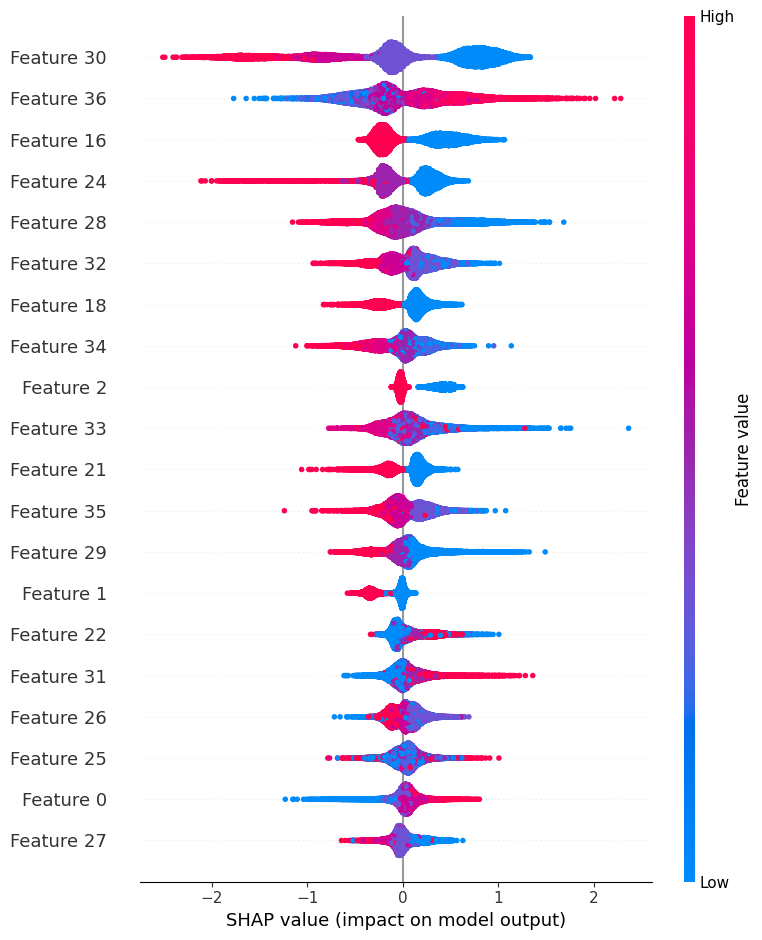

In [ ]:
explainer = shap.Explainer(best_clf)
shap_values_array = explainer.shap_values(X_test)
shap.summary_plot(shap_values_array, X_test)


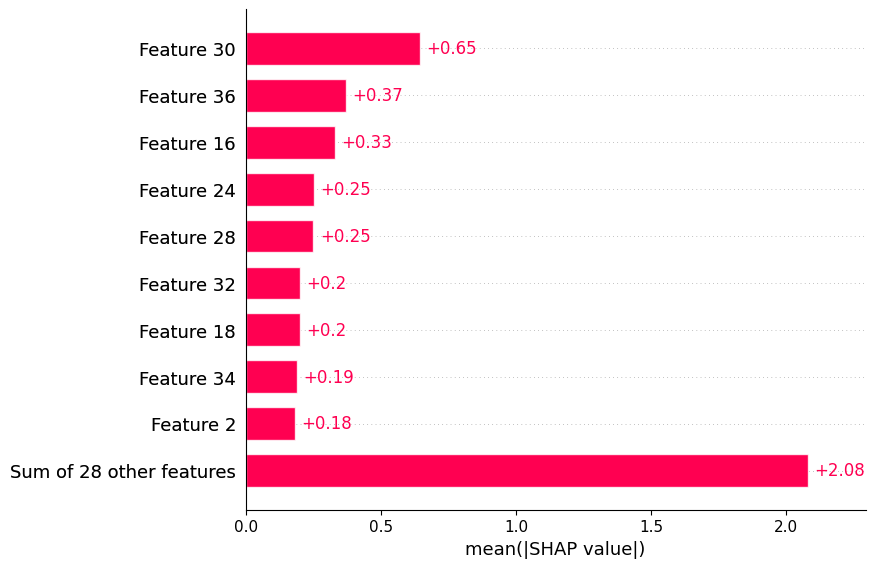

In [ ]:
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

# AUROC Curve Score

# Define target classification

OKS: New columns derived from pre-processing.

T0: Recorded outcomes before surgery (by physician/patient-reported).

T1: Recorded outcomes after surgery (by physician/patient-reported).

Correspondence to PROMS data dictionary: T0 corresponds to Q1 in the data dictionary, T1 corresponds to Q2 in the data dictionary (e.g. t0_living_arrangements = Q1_LIVING_ARRANGEMENTS).

In [ ]:
(lambda: DeepnoteChart(df, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#4c78a8","tooltip":true},"encoding":{"x":{"sort":null,"type":"quantitative","field":"t1_readmitted","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"y":{"sort":null,"type":"quantitative","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"count","formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""") if 'DeepnoteChart' in globals() else _dntk.DeepnoteChart(df, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#4c78a8","tooltip":true},"encoding":{"x":{"sort":null,"type":"quantitative","field":"t1_readmitted","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"y":{"sort":null,"type":"quantitative","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"count","formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}"""))()

# Defining proxy endpoint

In [ ]:
target_filter = (df["t0_mobility"] == 9) | (df["t1_mobility"] == 9)
filtered_df = df[~target_filter]
pre, post = filtered_df["t0_mobility"].astype(int), filtered_df["t1_mobility"].astype(int)

KeyError: 't1_mobility'

In [ ]:
# success = whether or not mobility score decreased (lower is better)
target = post - pre
target_bool = pd.Series([(d < 0) for d in target])

target_bool.value_counts()

False    67344
True     64806
dtype: int64

In [ ]:
# define features used for training
train_features = [feature for feature in filtered_df.columns if "t1" not in feature]
train_df = filtered_df[train_features]

In [ ]:
# Constructing a Quality of Life (QoL) Index
# Assuming 'X_test' contains the test features and 'y_test' contains the corresponding labels

# Define the most influential features identified from classification
influential_features = ['feature1', 'feature2', 'feature3']  

# Extract the influential features from the test set
X_influential = X_test[influential_features]

# Normalize the influential features to ensure they are on a similar scale
scaler = MinMaxScaler()
X_influential_scaled = scaler.fit_transform(X_influential)

# Define weights for the influential features
feature_weights = {'feature1': 0.3, 'feature2': 0.5, 'feature3': 0.2}  # Adjust weights as needed, sum up to 1

# Calculate the weighted sum of the normalized influential features to obtain the QoL index for each sample
QoL_index = np.dot(X_influential_scaled, np.array(list(feature_weights.values())))

# Optional: further normalization of the QoL index to a range of 0 to 100 
QoL_index_normalized = (QoL_index - np.min(QoL_index)) / (np.max(QoL_index) - np.min(QoL_index)) * 100

# Print the QoL index for each sample
print("Quality of Life (QoL) Index:")
for i, index_value in enumerate(QoL_index_normalized):
    print(f"Sample {i+1}: {index_value}")


In [ ]:
from scipy.stats import pearsonr, spearmanr

# Using the 

# Calculate correlation between constructed QoL index and PRO scores
pearson_corr, _ = pearsonr(QoL_index_normalized, oks_t1_score)
spearman_corr, _ = spearmanr(QoL_index_normalized, oks_t1_score)

print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

# Assuming 'baseline_pro_scores' contains PRO scores before knee replacement surgery
# 'postop_pro_scores' contains PRO scores after knee replacement surgery

# Calculate change in PRO scores before and after surgery
pro_change = oks_t1_score - oks_t0_score

# Calculate change in QoL index before and after surgery
qol_index_change = QoL_index_normalized_postop - QoL_index_normalized_baseline

# Calculate correlation between change in QoL index and change in PRO scores
change_corr, _ = pearsonr(qol_index_change, pro_change)

print(f"Correlation between Change in QoL Index and Change in PRO Scores: {change_corr}")

# Perform additional validation and analysis as needed


# Model training

In [ ]:
filtered_df.shape

(132150, 81)

In [ ]:
target_bool.shape

(132150,)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c0ad802-a1fc-4a79-aa06-80a8b80fc4c4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>